**submisson by Ajith Shenoy**

## Objective
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.



The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.



### The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.



## Business Goal

we are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

In [2]:
RANDOM_SEED = 42

In [3]:
def compute_alpha(X_train,y_train,
                    X_test,y_test,
                    model_type='RIDGE',
                    num_folds=10
                   ):

    hyper_param = {'alpha':[1e-6,1e-5,1e-4, 1e-3, 0.01, 0.05, 0.1, 
                            0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                            4.0, 5.0, 6.0,7.0]}
    
    model_cv = GridSearchCV(estimator = Ridge() if model_type=='RIDGE' else Lasso(),
                        param_grid=hyper_param,
                        scoring='neg_root_mean_squared_error',
                        cv=num_folds,
                        verbose=0,
                        n_jobs=-1,
                        return_train_score=True
                       )
    model_cv.fit(X_train,y_train)
    cv_result_l = pd.DataFrame(model_cv.cv_results_)
    cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
    
    plt.figure(figsize=(16,8))
    plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score']*-1,label = 'mean_train_score')
    plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score']*-1,label = 'mean_test_score')
    plt.xlabel('Alpha')
    plt.xscale('log')
    plt.ylabel('RMSLE')
    plt.legend()
    plt.title(f"RMSLE for different Alphas - {model_type}\n")
    plt.show()

    optimal_alpha = model_cv.best_params_

    print(f"\n Optimal Alpha for {model_type} : {optimal_alpha}\n")
    
    best_model = model_cv.best_estimator_

    model_parameter = list(best_model.coef_)
    model_parameter.append(best_model.intercept_)
    cols = list(X_train.columns)
    cols.append('constant')
    best_model_coef = pd.DataFrame(list(zip(cols,model_parameter)))
    best_model_coef.columns = ['Feature','Coef']
    best_model_coef['abs_coeff'] = abs(best_model_coef['Coef'])
    best_model_coef = best_model_coef.sort_values(by='abs_coeff',ascending=False)
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    train_r_squared = round(r2_score(y_train,y_train_pred),3)
    train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
    test_r_squred = round(r2_score(y_test,y_test_pred),3)
    test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
    
    print(f"\n {model_type} Training R-Squared:{train_r_squared},Test R-Squared:{test_r_squred} , Train RMSLE:{train_rmse} Test RMSLE:{test_rmse}\n")

    return best_model,best_model_coef

def get_linReg_model(
                    X_train,y_train,
                    X_test,y_test,
                    alpha,
                   model_type='Ridge',
                   top_n=10):
                   
    model  = Ridge(alpha = alpha) if model_type=='Ridge' else Lasso(alpha = alpha)
    model.fit(X_train,y_train)
    model_parameter = list(model.coef_)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r_squared = round(r2_score(y_train,y_train_pred),3)
    train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
    test_r_squred = round(r2_score(y_test,y_test_pred),3)
    test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

    print(f"\n {model_type} Training R-Squared:{train_r_squared},Test R-Squared:{test_r_squred} , Train RMSLE:{train_rmse} Test RMSLE:{test_rmse}\n")
    
    model_coef = pd.DataFrame(list(zip(model.feature_names_in_,model.coef_)))
    model_coef.columns = ['Feature','Coef']
    model_coef['abs_coeff'] = abs(model_coef['Coef'])
    model_coef = model_coef.sort_values(by='abs_coeff',ascending=False)
    
    return model,model_coef              

In [4]:
#file_url = "https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv"
df = pd.read_csv("train.csv",index_col='Id')
df.sample(3,random_state=RANDOM_SEED)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal,154500
1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,325000
414,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,115000


In [5]:
#checking datatypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

<Axes: xlabel='SalePrice', ylabel='Count'>

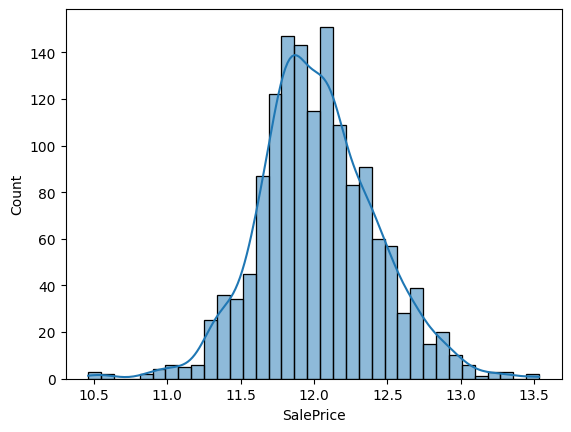

In [6]:
#checking target skewness can be fixed by log transformation
sns.histplot(np.log1p(df['SalePrice']),kde=True)

In [7]:
df['SalePrice'] = np.log1p(df['SalePrice'])

In [8]:
#TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF
#Alley, PoolQC and MiscFeature most values are null. We'll drop them.
cols_to_drop = ['Alley', 'PoolQC', 'MiscFeature','TotalBsmtSF']
df.drop(columns= cols_to_drop,inplace=True)
print(df.shape)

(1460, 76)


## Handling missing values

**Group 1: Numeric Variables with Nulls**

- `LotFrontage`: Replace missing values with a representative number or remove rows.
- `MasVnrArea`: Replace missing values with 0.
- `GarageYrBlt`: Replace missing values with a new number.

**Group 2: Categorical Variables with Nulls**

- `MasVnrType`: Replace missing values with a new category.
- `BsmtQual`: Replace missing values with a new category.
- `BsmtCond`: Replace missing values with a new category.
- `BsmtExposure`: Replace missing values with a new category.
- `BsmtFinType1`: Replace missing values with a new category.
- `BsmtFinType2`: Replace missing values with a new category.
- `Electrical`: Replace missing values with a representative category or remove rows.
- `FireplaceQu`: Replace missing values with a new category.
- `GarageType`: Replace missing values with a new category.
- `GarageFinish`: Replace missing values with a new category.
- `GarageQual`: Replace missing values with a new category.
- `GarageCond`: Replace missing values with a new category.
- `Fence`: Replace missing values with a new category.

In [9]:
# List of columns to fill with 'NA' or 0
cols_to_fill = ['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']

# Loop through each column and fill missing values
for col in cols_to_fill:
    df[col].fillna('NA' if df[col].dtype == 'O' else 0, inplace=True)

In [10]:
# Since only one record is missing we'll drop the null rows for Electrical , and also for LotFrontage
df.dropna(subset=['Electrical','LotFrontage'],inplace=True)

In [11]:
#GarageYrBlt,and YearBuilt could be interchanged , testing that claim
df[['GarageYrBlt','YearBuilt']].corr()

,GarageYrBlt,YearBuilt
GarageYrBlt,1.000000,0.824372
YearBuilt,0.824372,1.000000


In [12]:
df.drop(['GarageYrBlt'],axis=1,inplace=True)

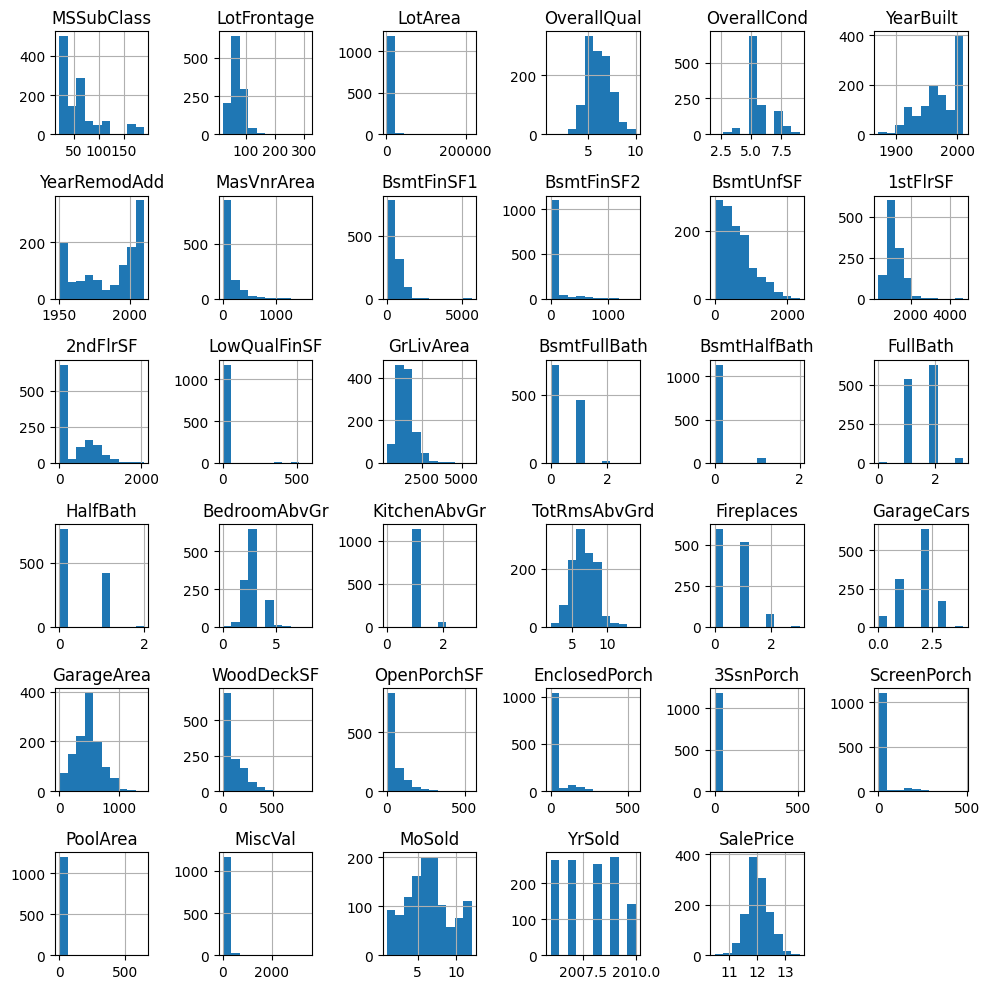

In [13]:
df.hist(figsize=(10, 10));
plt.tight_layout();

### Checking Sparsisity among the skewed features

In [14]:
print('\nFeature with the Count of their non zero values\n')
df.select_dtypes('number').apply(lambda x: x>0).sum().sort_values().reset_index().head()


Feature with the Count of their non zero values



,index,0
0,PoolArea,6
1,3SsnPorch,18
2,LowQualFinSF,24
3,MiscVal,37
4,BsmtHalfBath,63


In [15]:
sparse_skewed_cols = ['LowQualFinSF','3SsnPorch','PoolArea','MiscVal','BsmtHalfBath']
df.drop(columns = sparse_skewed_cols,axis=1,inplace=True)

In [16]:
# Excluding Outliers
key_columns = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','WoodDeckSF',
                     'OpenPorchSF','EnclosedPorch','ScreenPorch']
#Looks good. We can now drop the outlier rows
for column in key_columns:
    q_hi  = df[column].quantile(0.99)
    df = df[(df[column] < q_hi)]

print(df.shape)

(1104, 70)


## Correlation Analysis

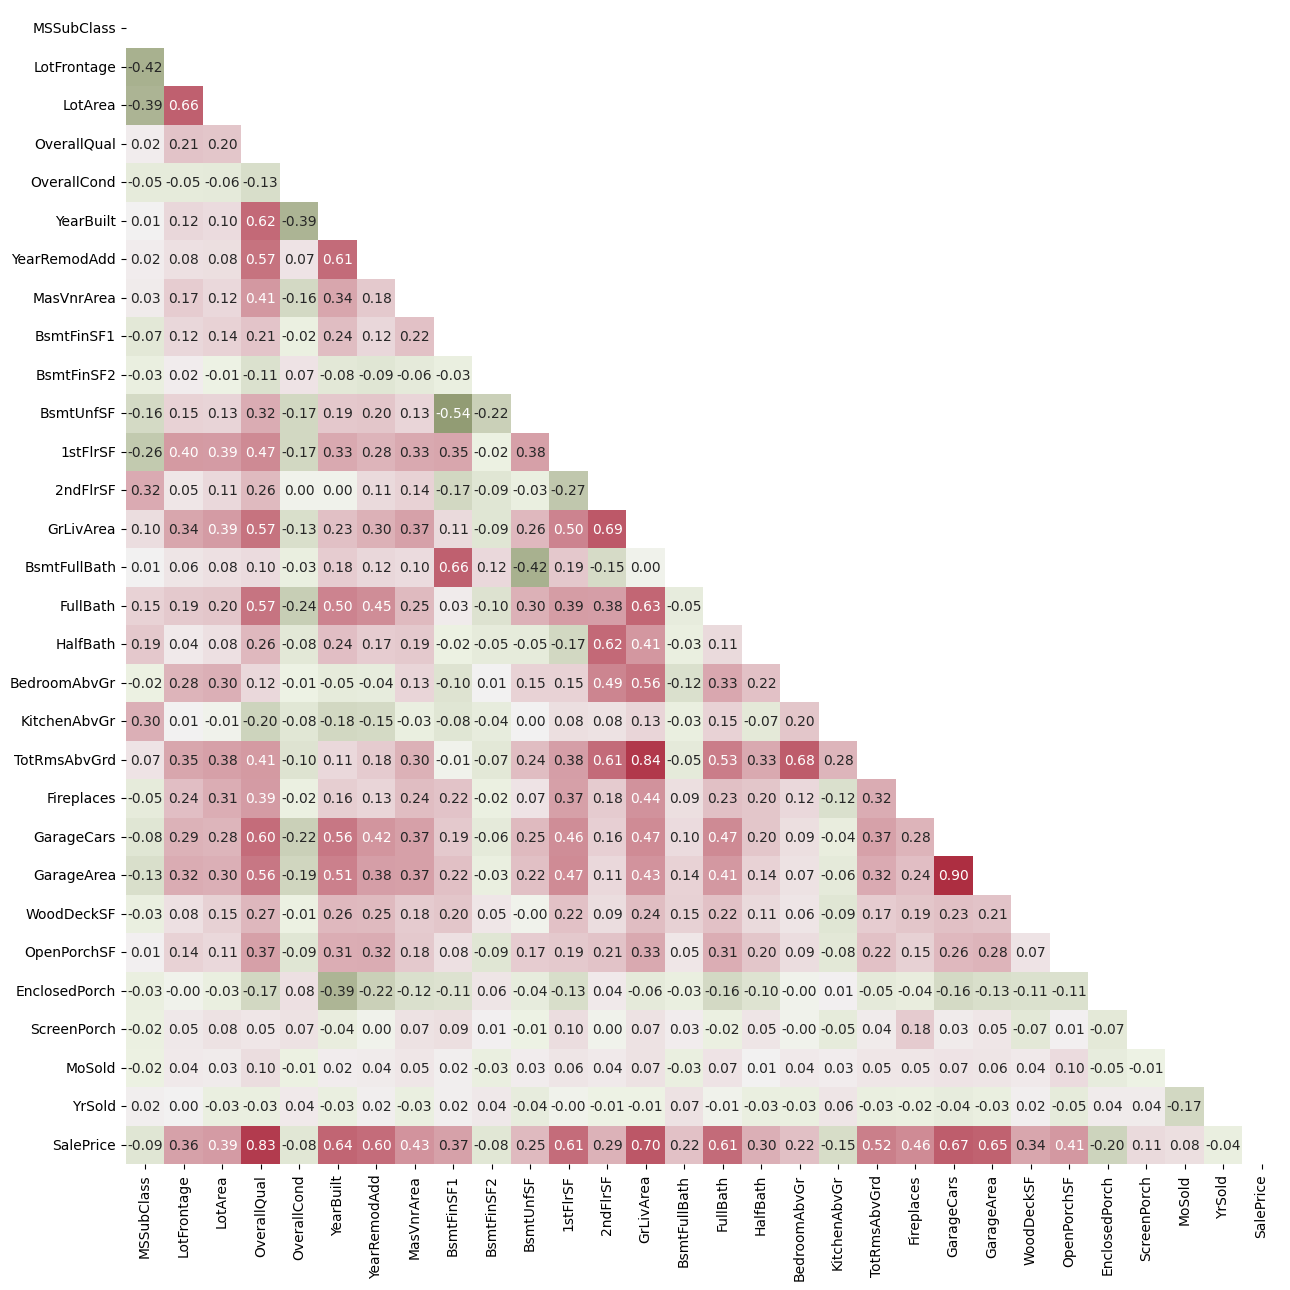

In [17]:
corr =  df.corr(numeric_only=True)

# Create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(15,15))
sns.heatmap(corr, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap,cbar=False)

plt.show();

strongly correlated terms:
- GarageArea - GarageCars: 0.90
- TotRmsAbvGrd - GrLivArea: 0.84
- Quantitavely area variables are more significant. Thus keeping them.

In [18]:
df.drop(columns=['GarageCars','TotRmsAbvGrd'],inplace=True)

# EDA

## Categorizing the columns

In [19]:
num_cols = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',
           'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF',
           'GrLivArea','BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
            'Fireplaces','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
           'ScreenPorch','MoSold','YrSold','MasVnrArea']
nom_cols = ['MSSubClass','MSZoning','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
            'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
           'Heating','Electrical','Functional','GarageType','SaleType',
           'SaleCondition']
ord_cols = ['Street','LotShape','LandContour','Utilities','LandSlope','ExterQual',
            'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
           'HeatingQC','CentralAir','KitchenQual','FireplaceQu','GarageFinish',
           'GarageQual','GarageCond','PavedDrive','Fence']

target = 'SalePrice'

Measuring Impact of Categorical Variables on Sales Price

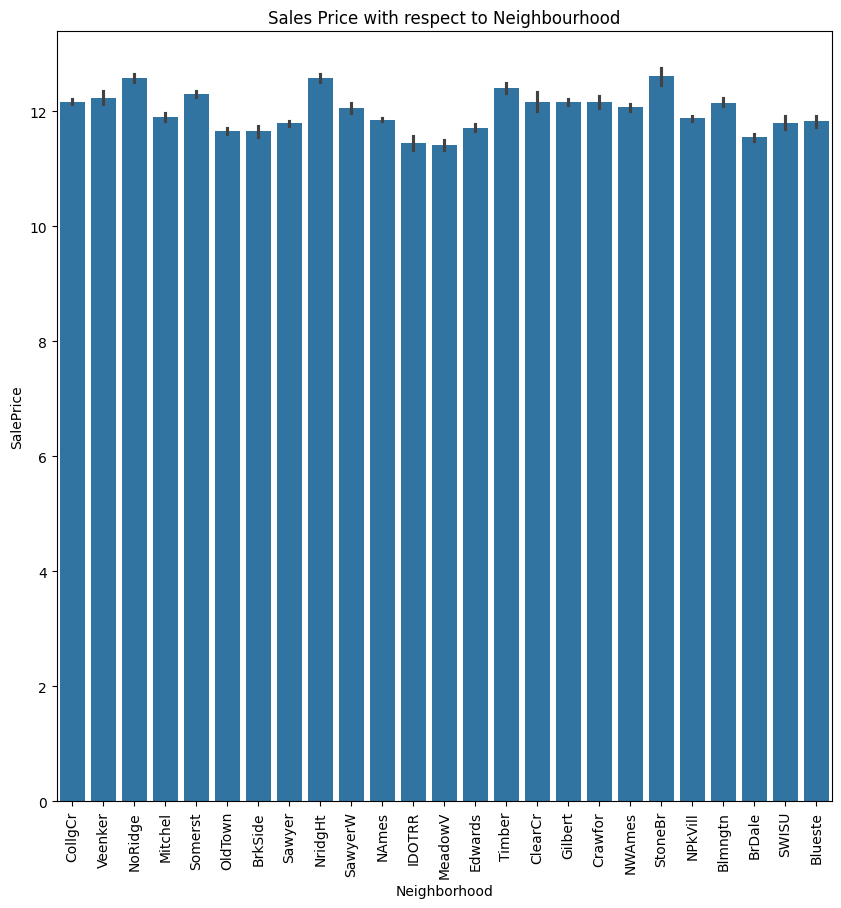

In [20]:
# plot 'Sale Price' with respect to 'Neighborhood'

plt.figure(figsize=(10,10))
sns.barplot(x="Neighborhood", y="SalePrice", data= df)
plt.title("Sales Price with respect to Neighbourhood")
plt.xticks(rotation=90)
plt.show()

Properties in some of the Neighborhoods are highly priced.

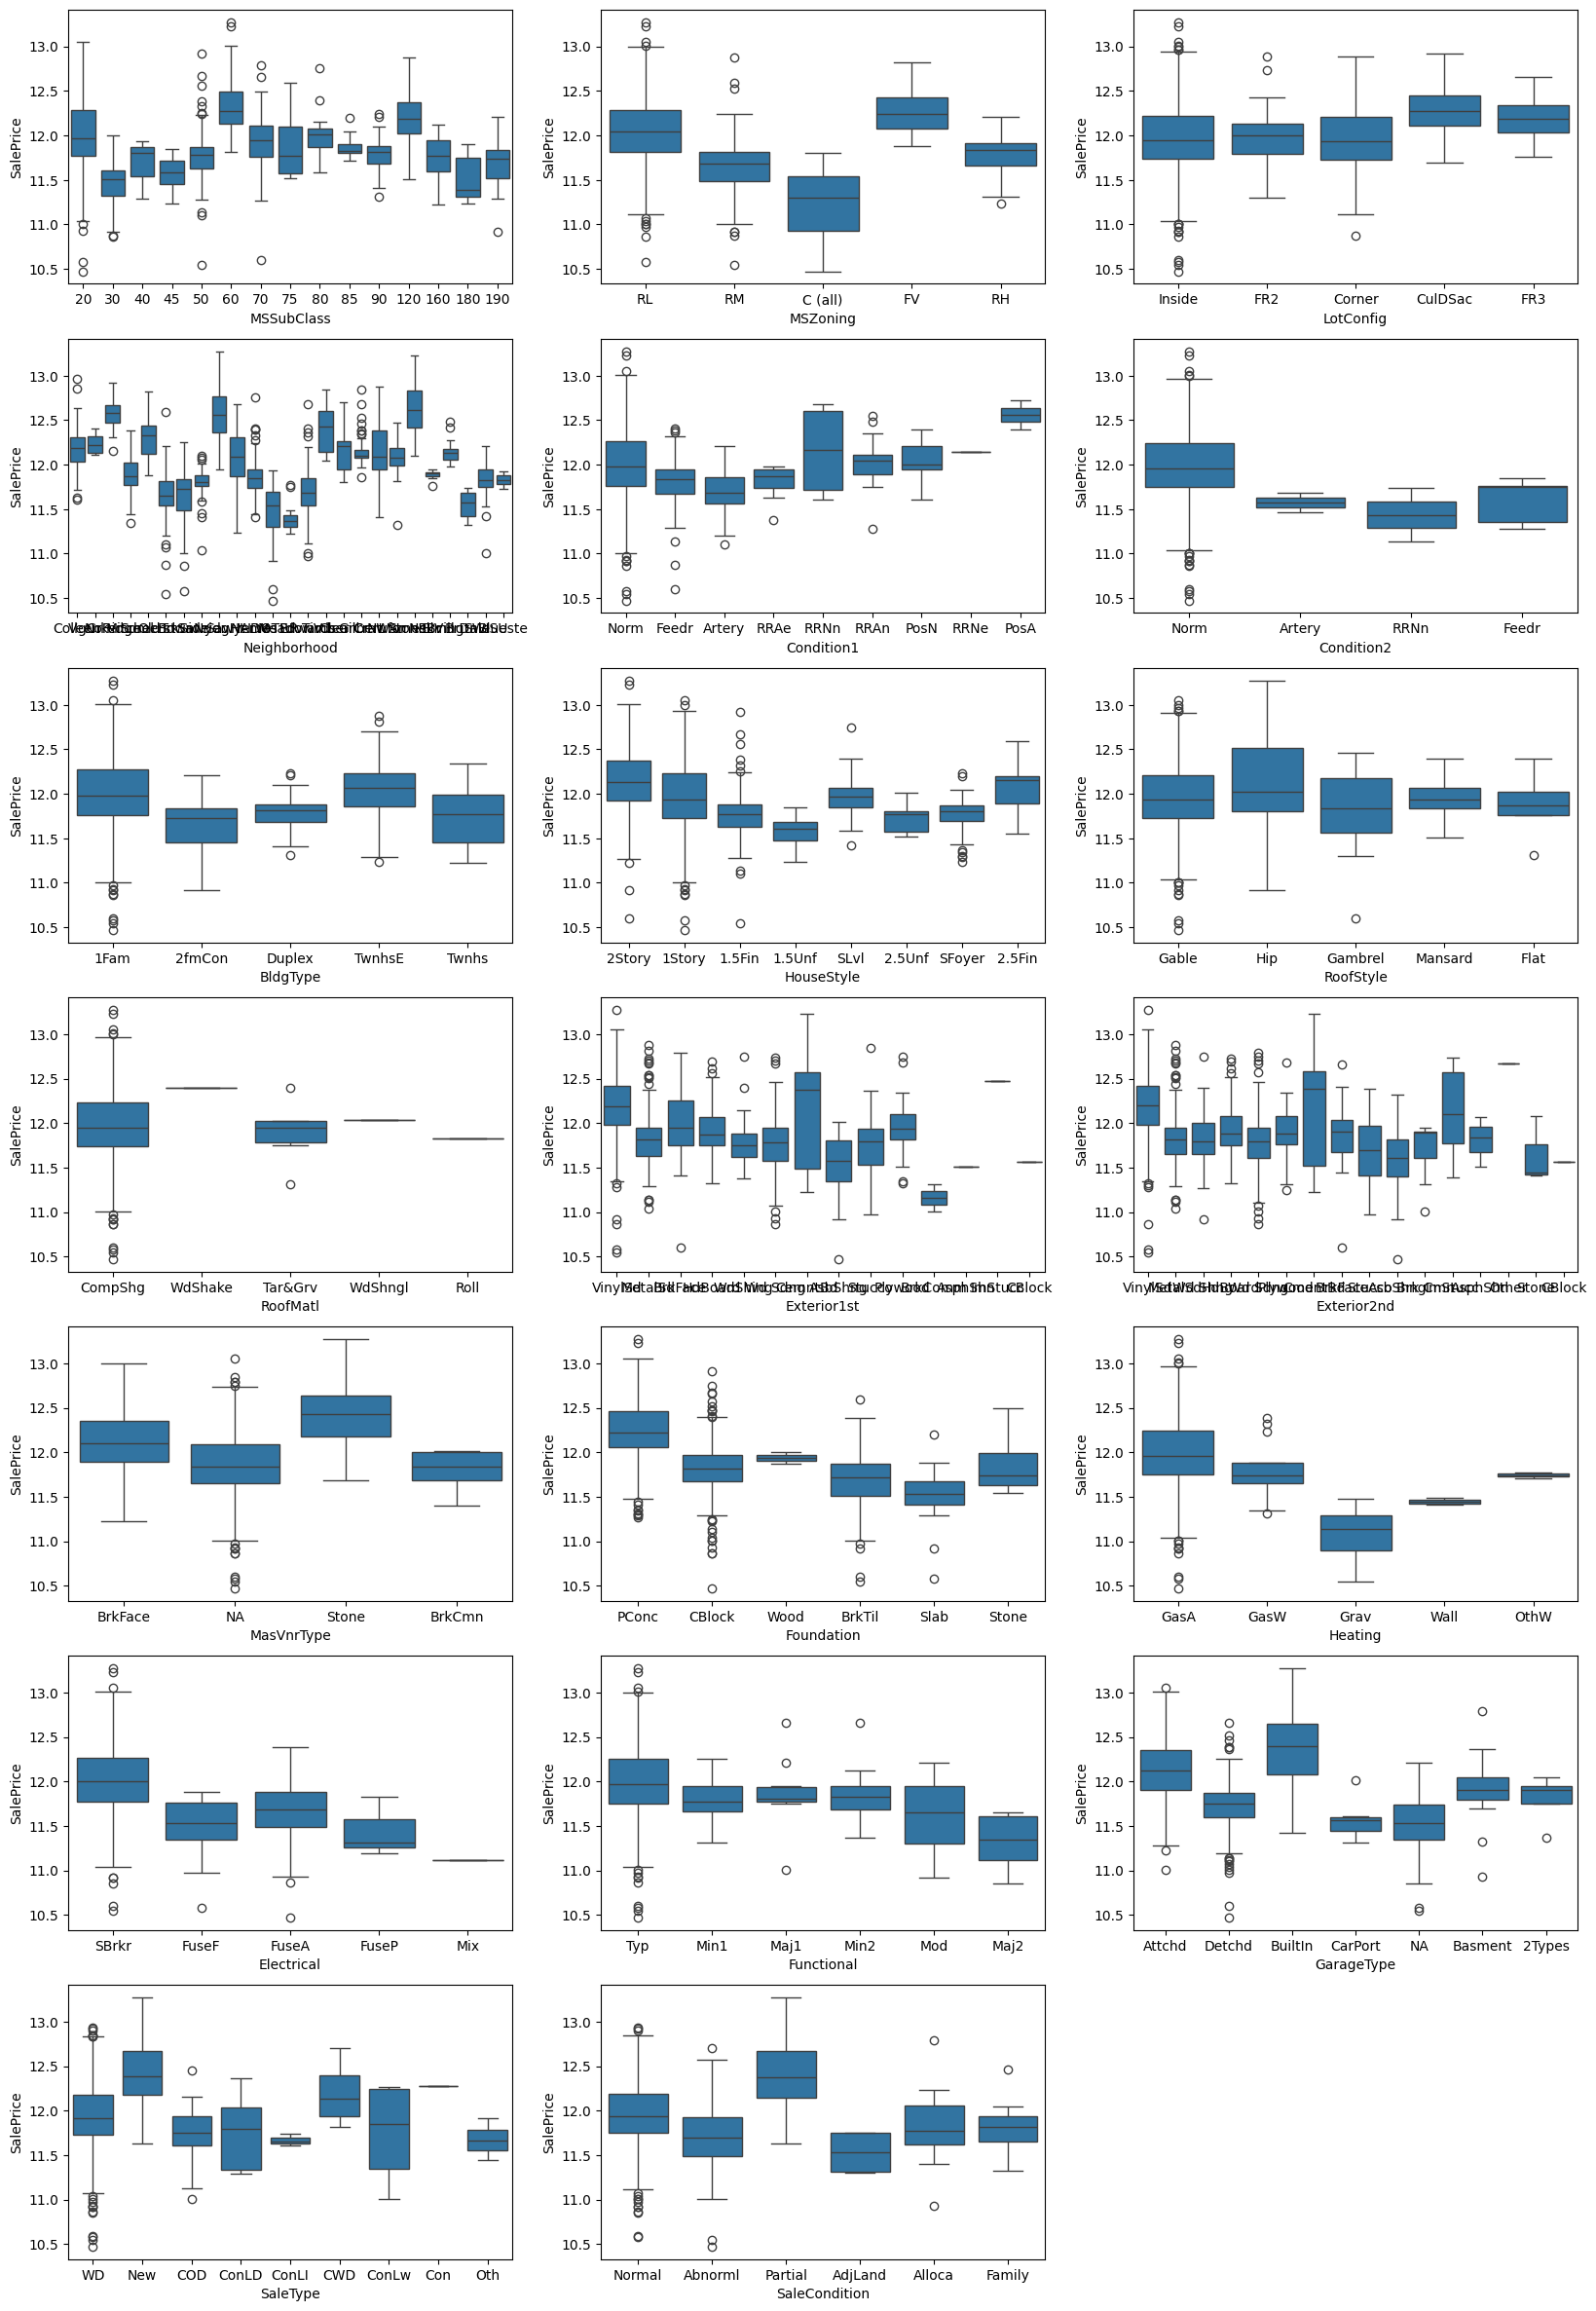

In [21]:
plt.figure(figsize=(20,30))
i = 1
for col in list(nom_cols):
    plt.subplot(len(nom_cols)//3+1,3,i)
    sns.boxplot(data=df, y = 'SalePrice',x = col)
    i+=1
plt.show()

- All nominal variables seem to have some effect on the SalePrice. Feature Importance is hard to determine.

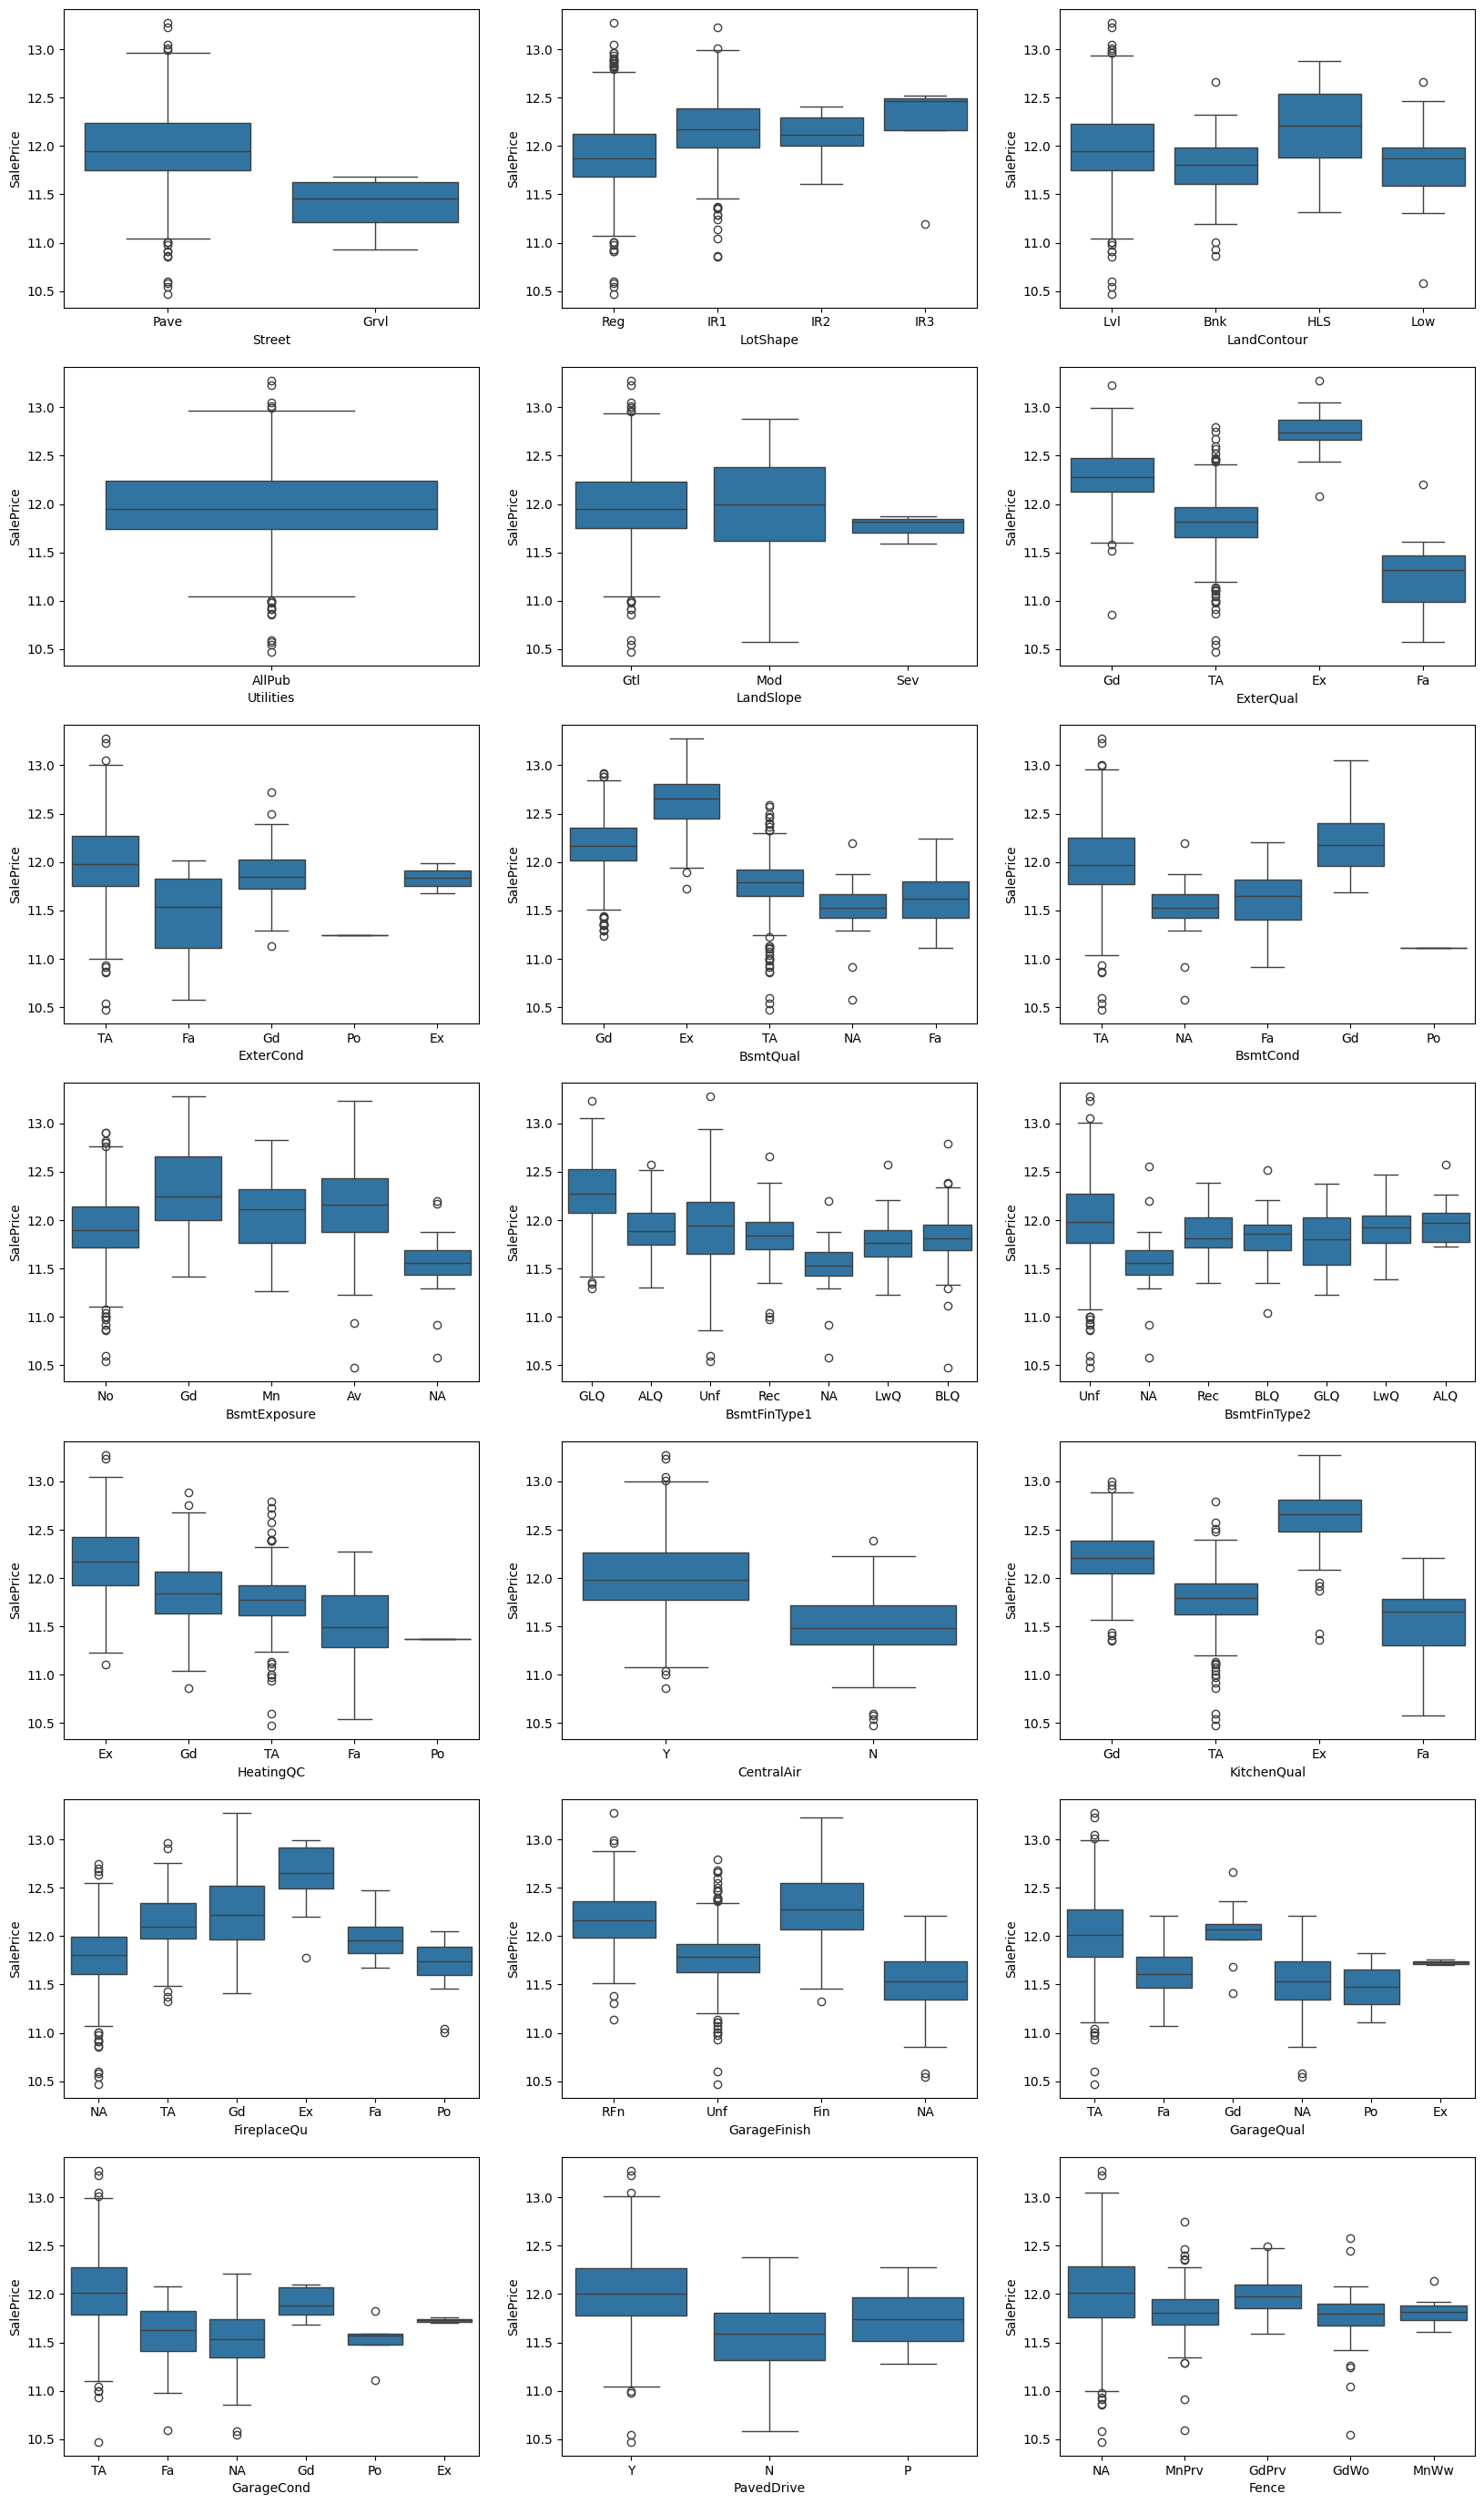

In [22]:
#ordinal features
plt.figure(figsize=(20,40))
i = 1
for col in list(ord_cols):
    plt.subplot(len(ord_cols)//3+1,3,i)
    sns.boxplot(data=df, y = 'SalePrice',x = col)
    i+=1
plt.show()

In [23]:
# All utilities seem to have only one value: AllPub. dropping Utilities
df.drop(['Utilities'],axis=1,inplace=True)
ord_cols.remove('Utilities')

## Feature Engineering

#### Feature Transformations

In [24]:
#Converting nominal features to numeric
for col in nom_cols:
    df[col] = df[col].apply(lambda x: col+'_'+str(x))
    status = pd.get_dummies(df[col],drop_first=True)
    df = pd.concat([df,status],axis=1)
    df=df.drop(col,axis=1)

In [25]:
#Converting Ordinal data into numbers
df['Street'] = df.Street.map({'Grvl':0,'Pave':1})
df['LotShape'] = df.LotShape.map({'IR3':0,'IR2':1,'IR1':2,'Reg':3})
df['LandContour'] = df.LandContour.map({'Low':0,'HLS':1,'Bnk':2,'Lvl':3})
df['LandSlope'] = df.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
df['ExterQual'] = df.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
df['ExterCond'] = df.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
df['BsmtQual'] = df.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['BsmtCond'] = df.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['BsmtExposure'] = df.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
df['BsmtFinType1'] = df.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
df['BsmtFinType2'] = df.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
df['HeatingQC'] = df.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
df['CentralAir'] = df.CentralAir.map({'N':0,'Y':1})
df['KitchenQual'] = df.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
df['FireplaceQu'] = df.FireplaceQu.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['GarageFinish'] = df.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
df['GarageQual'] = df.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['GarageCond'] = df.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['PavedDrive'] = df.PavedDrive.map({'N':0,'P':1,'Y':2})
df['Fence'] = df.Fence.map({'NA':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4})

In [26]:
df.sample(5,random_state=RANDOM_SEED)

,LotFrontage,LotArea,Street,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
409,109.0,14154,1,3,3,0,7,5,2006,2006,...,False,False,True,False,False,False,False,False,False,True
1381,45.0,8212,1,3,3,0,3,3,1914,1950,...,False,False,False,False,True,False,False,False,True,False
503,70.0,9170,1,3,3,0,5,7,1965,1965,...,False,False,False,False,True,False,False,False,True,False
649,70.0,7700,1,3,3,0,6,5,1966,1966,...,False,False,False,False,True,False,False,False,True,False
720,69.0,9920,1,2,3,0,5,6,1969,1969,...,False,False,False,False,True,False,False,False,True,False


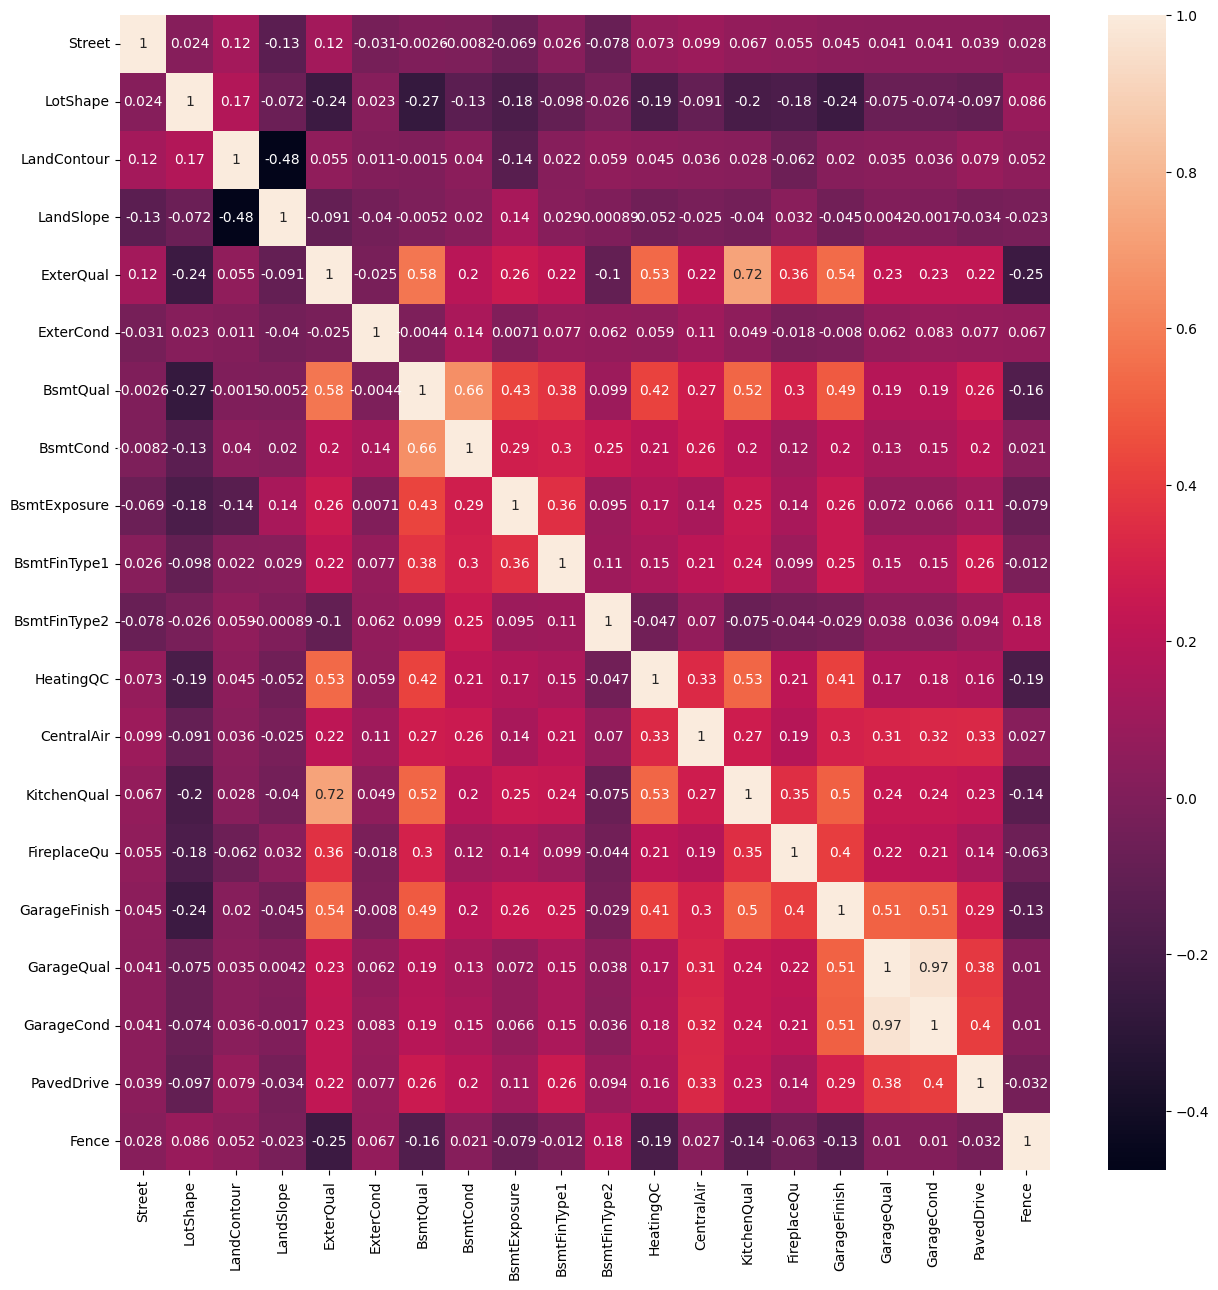

In [27]:
plt.figure(figsize=(15,15))
sns.heatmap(df[ord_cols].corr(),annot=True)
plt.show()

In [28]:
# There is a strong correlation between GarageQual and GarageCond.
# Dropping GarageQual
df.drop(['GarageQual'],axis=1,inplace=True)
ord_cols.remove('GarageQual')

# Model Building

In [29]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target),df[target].values, test_size=0.15, random_state=RANDOM_SEED)
print(X_train.shape,X_test.shape)

(938, 189) (166, 189)


### Feature Scaling

In [30]:
scaler = MinMaxScaler()

X_train.loc[:,num_cols+ord_cols] = scaler.fit_transform(X_train[num_cols+ord_cols])
X_test.loc[:,num_cols+ord_cols] = scaler.transform(X_test[num_cols+ord_cols])

## Ridge Model

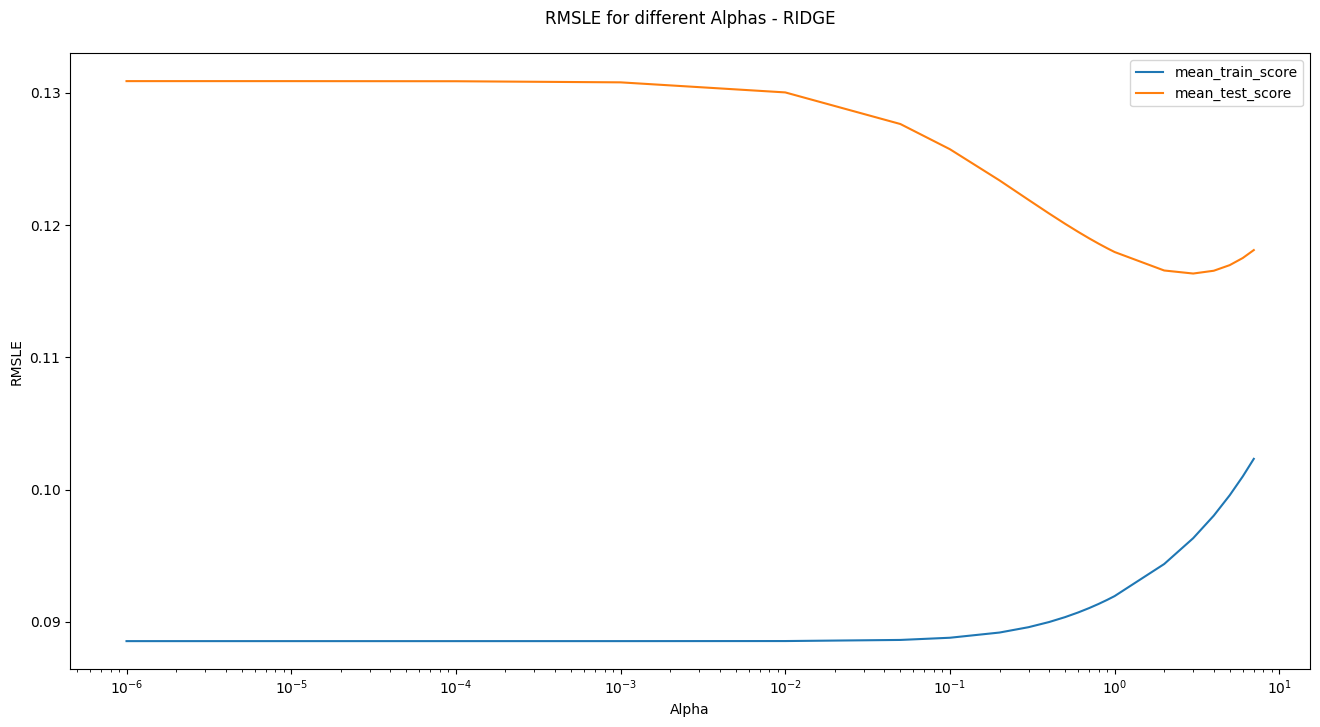


 Optimal Alpha for RIDGE : {'alpha': 3.0}


 RIDGE Training R-Squared:0.938,Test R-Squared:0.92 , Train RMSLE:0.09697402476685499 Test RMSLE:0.11778828632596106



,Feature,Coef,abs_coeff
189,constant,10.315882,10.315882
6,OverallQual,0.299845,0.299845
23,1stFlrSF,0.298740,0.298740
25,GrLivArea,0.267975,0.267975
7,OverallCond,0.196243,0.196243


In [31]:
best_ridge_model,ridge_coefficients = compute_alpha(X_train,y_train,X_test,y_test)
ridge_coefficients.head(5)

## Doubling the alpha

In [32]:
double_alpha_ridge,double_alpha_ridge_coeff = get_linReg_model(X_train,y_train,
                                                               X_test,y_test,
                                                               alpha=6.0)
double_alpha_ridge_coeff.head(10)


 Ridge Training R-Squared:0.933,Test R-Squared:0.919 , Train RMSLE:0.10119679541862461 Test RMSLE:0.11887965789192964



,Feature,Coef,abs_coeff
23,1stFlrSF,0.276605,0.276605
6,OverallQual,0.249783,0.249783
25,GrLivArea,0.242000,0.242000
7,OverallCond,0.162258,0.162258
17,BsmtFinSF1,0.156875,0.156875
35,GarageArea,0.141116,0.141116
27,FullBath,0.135164,0.135164
24,2ndFlrSF,0.133616,0.133616
1,LotArea,0.127749,0.127749
72,Neighborhood_Crawfor,0.110530,0.110530


# Lasso

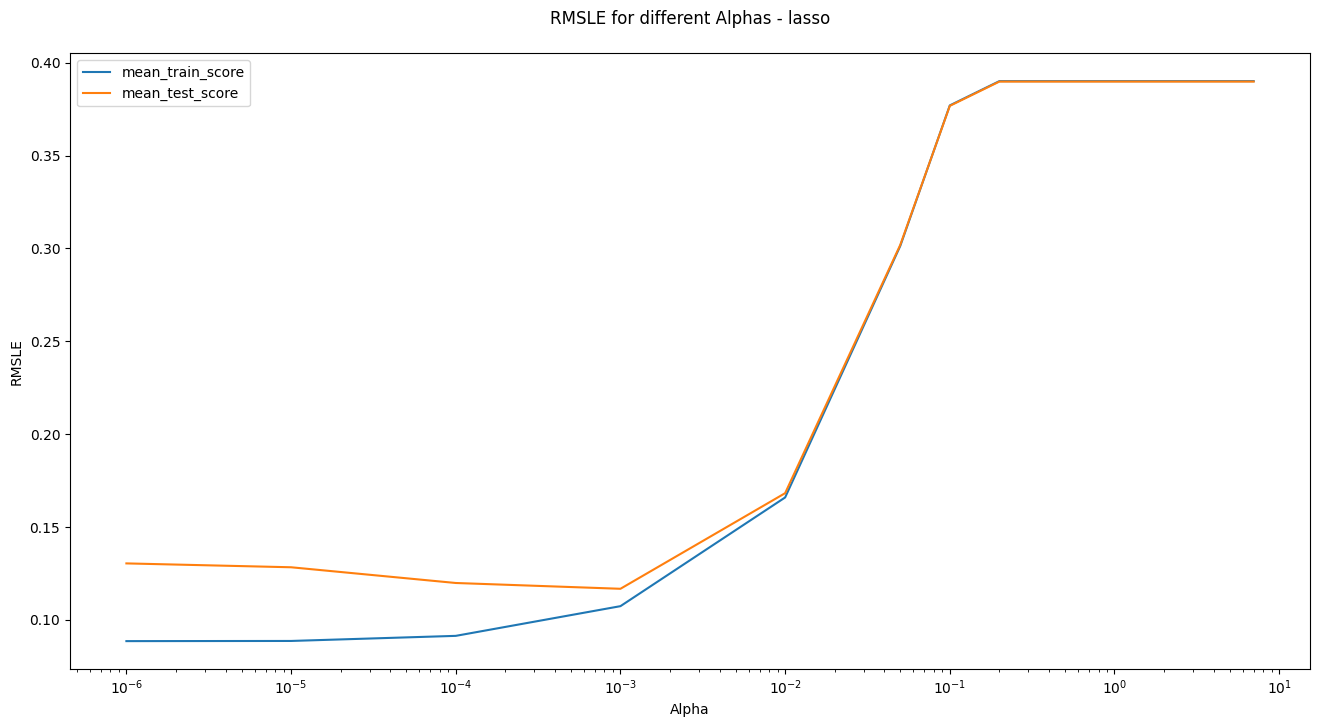


 Optimal Alpha for lasso : {'alpha': 0.001}


 lasso Training R-Squared:0.923,Test R-Squared:0.922 , Train RMSLE:0.10818423823112042 Test RMSLE:0.1165539699833518


129 have zero coefficients out of 189 features.



,Feature,Coef,abs_coeff
189,constant,10.444429,10.444429
25,GrLivArea,0.667303,0.667303
6,OverallQual,0.484866,0.484866
23,1stFlrSF,0.218877,0.218877
7,OverallCond,0.212046,0.212046


In [33]:
best_lasso_model,lasso_coefficients = compute_alpha(X_train,y_train,X_test,y_test,model_type='lasso')
zero_coefficients = sum(abs(lasso_coefficients['Coef']) == 0.0)
print(f"\n{zero_coefficients} have zero coefficients out of {len(X_train.columns)} features.\n")
lasso_coefficients.head(5)

In [34]:
top_5_features  =  list(lasso_coefficients['Feature'][:6])
top_5_features.remove('constant')
print(f"Top 5 Features LASSO:{top_5_features}")

Top 5 Features LASSO:['GrLivArea', 'OverallQual', '1stFlrSF', 'OverallCond', 'GarageArea']


## Doubling the Alpha

In [35]:
double_alpha_lasso,double_alpha_lasso_coeff = get_linReg_model(X_train,y_train,
                                                               X_test,y_test,
                                                               model_type = 'Lasso',
                                                               alpha=(0.001*2))
zero_coefficients_double = sum(abs(double_alpha_lasso_coeff['Coef']) == 0.0)
print(f"\n{zero_coefficients_double} have zero coefficients out of {len(X_train.columns)} features.\n")
double_alpha_lasso_coeff.head(10)


 Lasso Training R-Squared:0.911,Test R-Squared:0.913 , Train RMSLE:0.11640931963636007 Test RMSLE:0.12307623214225766


146 have zero coefficients out of 189 features.



,Feature,Coef,abs_coeff
25,GrLivArea,0.613745,0.613745
6,OverallQual,0.496547,0.496547
23,1stFlrSF,0.258086,0.258086
35,GarageArea,0.180660,0.180660
7,OverallCond,0.127521,0.127521
17,BsmtFinSF1,0.124733,0.124733
1,LotArea,0.092415,0.092415
72,Neighborhood_Crawfor,0.086593,0.086593
13,BsmtQual,0.085968,0.085968
181,SaleType_New,0.077747,0.077747


## Lasso After Removing top 5 Variables

In [36]:
X_train_without_imp =  X_train.drop(columns=top_5_features)
X_test_without_imp = X_test.drop(columns=top_5_features)
print(X_train_without_imp.shape)

(938, 184)


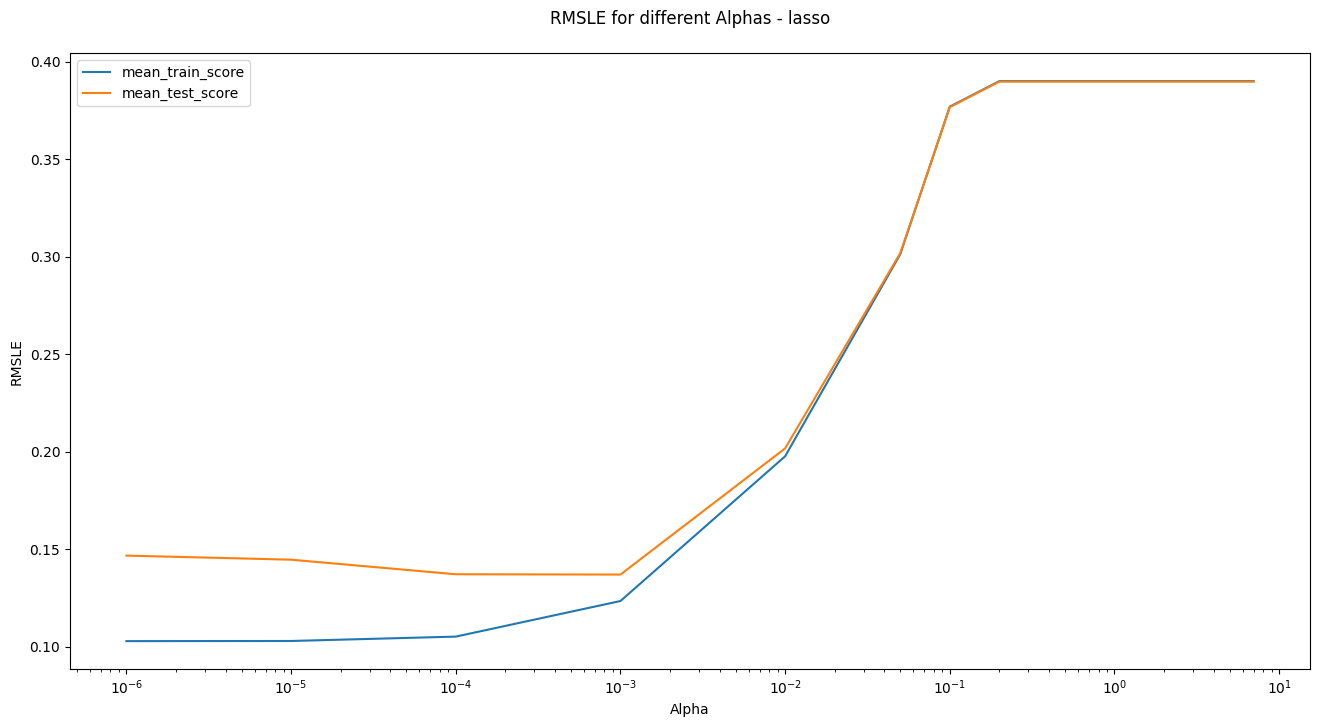


 Optimal Alpha for lasso : {'alpha': 0.001}


 lasso Training R-Squared:0.898,Test R-Squared:0.893 , Train RMSLE:0.1243939136420765 Test RMSLE:0.13621745296379287



In [37]:
trimmed_lasso_model,trimmed_lasso_coefficients = compute_alpha(X_train_without_imp,y_train,X_test_without_imp,y_test,model_type='lasso')

In [38]:
trimmed_top_5_features  =  list(trimmed_lasso_coefficients['Feature'][:6])
trimmed_top_5_features.remove('constant')
print(f"Top 5 Features after removing the most important features:{trimmed_top_5_features}")

Top 5 Features after removing the most important features:['BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF', 'FullBath', 'LotArea']


## Conclusion

- Optimal alpha value for ridge is : **3.0** and for lasso its **0.001**
- We will choose **Lasso** as the best model with alpha value 0.001 ,as it enables feature selection the performance is also quite good.
- lasso Training R-Squared:0.923,Test R-Squared:0.922 , Train RMSLE:0.108 Test RMSLE:0.117
- 'GrLivArea', 'OverallQual', '1stFlrSF', 'OverallCond', 'GarageArea' are the top 5 most important features that infleunce sale price.